# 개요
이 노트북은 과제4를 위해 BOHB 하이퍼 파라미터 최적화 기법을 사용하여 mnist 데이터셋을 분류하는 CNN을 훈련시키는데 가장 적합한 하이퍼 파라미터를 찾아내는 코드 입니다.

# 주의
이 노트북은 빠른 실행을 위한 Colab의 GPU 설정과 훈련 과정 저장을 위한 Google 드라이브 사용이 포함되어있으므로 실행을 위해 **Google 계정 및 드라이브 연동이 필요합니다**. 또한 실행 중 드라이브 권한 승인을 위한 팝업이 나올 수 있습니다.

# 사용법
1. **학습 실행** 전 까지 코드를 전부 실행합니다. 구글 드라이브 연동 권한에 대한 팝업이 등장하면 승인합니다.

2. **학습 실행** 에서는 **원하는 epoch까지 실행한 뒤, 실행을 종료**시키면 됩니다.(기본으로는 100 epoch까지 실행되어 사실상 끝나지 않습니다. 숫자를 수정하여 특정 epoch에서 종료시킬 수 있습니다.)

3. 이후 분석을 위한 코드를 실행시킵니다.

학습 실행을 하지 않더라도 **1.** 과정만 진행한 뒤, 드라이브에 생성된 "/content/drive/My Drive/HW4_results"폴더에 첨부된 pkl 파일을 넣으면 과제에 사용된 통계를 다시 확인할 수 있습니다.



# GPU 사용

코랩의 GPU 사용을 위한 설정입니다

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# 라이브러리 설치

BOHB를 위한 라이브러리는 Colab에 기본으로 설치되어 있지 않기 때문에 별도로 설치합니다.

In [2]:
!pip install hpbandster
!pip install ConfigSpace

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=79991 sha256=2df2a24112f35e9c8708812db8389c81e560349f4563e4e31f2e969fed6b7822
  Stored in directory: /root/.cache/pip/wheels/79/51/18/33d6ba8c55cc8401bffbccb1b87b21e0c68f40edc4ce3c1f99
  Created wheel for netifaces: filename=netifaces-0.11.0-cp310-cp310-linux_x86_64.whl size=35005 sha256=fd9c435d4244118b48e6765ed7cef0d625a2a5e4d3ec8572314ea45c56ffeb8c
  Stored in directory: /root/.cache/pip/wheels/48/65/b3/4c4cc6038b81ff21cc9df69f2b6774f5f52e23d3c275ed15aa
Successfully built hpbandster netifaces


# 전처리(데이터 다운로드 및 나누기)

간단한 전처리입니다.

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# 데이터셋 로드
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 전처리
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# 2.4. train data를 4:1로 분할하여 validation data 생성
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


11490434/11490434 [==============================] - 1s 0us/step


# 데이터 증강

과적합을 방지하기 위한 데이터 증강입니다.

In [4]:
# 3. 데이터 증강
from keras.preprocessing.image import ImageDataGenerator
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    fill_mode = 'nearest'
)

# 모델 정의

In [5]:
from tensorflow.keras import layers, models, regularizers, optimizers, callbacks, metrics
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dropout, Dense, Add, DepthwiseConv2D
def inverted_residual_block(inputs, filters, stride, expansion, l2):
    x = inputs
    in_channels = x.shape[-1]
    x = Conv2D(expansion * in_channels, kernel_size=1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = DepthwiseConv2D(kernel_size=3, strides=stride, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = Conv2D(filters, kernel_size=1, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = BatchNormalization()(x)

    if stride == 1 and in_channels == filters:
        x = Add()([inputs, x])

    return x

def MobileNetV2(input_shape=(28, 28, 1), num_classes=10, expansion=3, dropout=0.2, l2=0.003):
    inputs = Input(shape=input_shape)

    x = Conv2D(16, kernel_size=3, strides=2, padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(l2))(inputs)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = inverted_residual_block(x, filters=16, stride=1, expansion=1, l2=l2)

    x = inverted_residual_block(x, filters=24, stride=1, expansion=expansion, l2=l2)
    x = inverted_residual_block(x, filters=24, stride=1, expansion=expansion, l2=l2)

    x = inverted_residual_block(x, filters=32, stride=2, expansion=expansion, l2=l2)
    x = inverted_residual_block(x, filters=32, stride=1, expansion=expansion, l2=l2)
    x = inverted_residual_block(x, filters=32, stride=1, expansion=expansion, l2=l2)

    x = inverted_residual_block(x, filters=64, stride=1, expansion=expansion, l2=l2)

    x = Conv2D(256, kernel_size=1, use_bias=False, kernel_regularizer=tf.keras.regularizers.l2(l2))(x)
    x = BatchNormalization()(x)
    x = ReLU(6.)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, x)
    return model


In [6]:
def create_model(
	momentum=0.9,
	initial_lr=0.001,
	reduce_lr_factor=0.9,
	reduce_lr_patience=6,
	expansion=3,
	dropout=0.2,
	l2=0.003,
):
	model = MobileNetV2(expansion = expansion,dropout=dropout,l2=l2)

	optimizer=optimizers.RMSprop(
		learning_rate = initial_lr,
		momentum=momentum,
	)

	model.compile(
		optimizer=optimizer,
		loss='categorical_crossentropy',
		metrics=['categorical_accuracy']
	)
	return model

# 학습 정의

In [7]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
import torch

import tensorflow as tf
from hpbandster.core.worker import Worker
from tensorflow.keras.callbacks import EarlyStopping
class MyWorker(Worker):
    def compute(self, config, budget, *args, **kwargs):

        print("Hyperparameters:", config)  # 현재 하이퍼파라미터 출력

        # 하이퍼파라미터들
        momentum = config['momentum']
        initial_lr = config['initial_lr']
        batch_size = 2 ** config['batch_size_exp']
        expansion = config['expansion']
        dropout = config['dropout']
        reduce_lr_patience = config['reduce_lr_patience']
        reduce_lr_factor = config['reduce_lr_factor']
        l2 = config['l2']

        # 모델 생성
        model = create_model(
            momentum=momentum,
			initial_lr=initial_lr,
			reduce_lr_factor=reduce_lr_factor,
			reduce_lr_patience=reduce_lr_patience,
			expansion=expansion,
			dropout=dropout,
			l2=l2,
        )

        # EarlyStopping 콜백 정의
        early_stopping = EarlyStopping(
            monitor='val_categorical_accuracy',  # 검증 손실 기반으로 모니터링
            patience=10,  # 10 에폭 동안 성능 향상이 없으면 학습 조기 종료
            restore_best_weights=True,  # 최적의 가중치로 복원
        )

        # ReduceLROnPlateau 콜백 정의
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_categorical_accuracy',
            factor=reduce_lr_factor,
            patience=reduce_lr_patience,
        )
        model.fit(
            datagen.flow(x_train.reshape(-1, 28, 28, 1), y_train, batch_size=batch_size),  # 데이터 증강 적용
            epochs=int(budget),
            verbose=1,
            validation_data=(x_val.reshape(-1, 28, 28, 1), y_val),
            callbacks=[reduce_lr, early_stopping],
        )

        loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
        return {'loss': -accuracy, 'info': {'test_accuracy': accuracy}}

# 하이퍼파라미터 범위 정의

In [8]:
import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH
def get_configspace():
    cs = CS.ConfigurationSpace()

    # 하이퍼파라미터 추가
    cs.add_hyperparameters([
        CSH.UniformIntegerHyperparameter('batch_size_exp', lower=7, upper=9, default_value=8),
        CSH.UniformFloatHyperparameter('dropout', lower=0, upper=0.3, default_value=0.2),
        CSH.UniformIntegerHyperparameter('expansion', lower=2, upper=6, default_value=3),
        CSH.UniformFloatHyperparameter('initial_lr', lower=1e-5, upper=1e-1, log=True, default_value=1e-3),
        CSH.UniformFloatHyperparameter('l2', lower=1e-5, upper=1e-2, log=True, default_value=0.003),
        CSH.UniformFloatHyperparameter('momentum', lower=0.4, upper=1, default_value=0.9),
        CSH.UniformFloatHyperparameter('reduce_lr_factor', lower=0.05, upper=0.9, default_value=0.9),
        CSH.UniformIntegerHyperparameter('reduce_lr_patience', lower=4, upper=8, default_value=6),
        ])

    return cs

# 학습 실행

- 매 iteration 마다 실행 내역이 google drive에 저장되므로, 실행 중간에 종료하더라도 마지막 iteration 내용 까지 파일로 저장됩니다.
- 아래 반복문의 회수를 수정하면 실행 epoch 수를 수정할 수 있습니다.
      # BOHB 실행 및 결과 저장
      for i in range(100): # <-- 여기를 수정하면 epoch 수를 수정할 수 있습니다.
        result = bohb.run(n_iterations=1)
        print("current iter: ", result.num_iterations())
        # iteration 종료 시 결과 저장
        # 결과 저장
        with open(os.path.join(SAVE_DIR, 'results.pkl'), 'wb') as fh:
            pickle.dump(result, fh)

# ❗주의❗
- 한 번 실행 중간에 종료하면 워커가 계속 남아있는 문제가 있으나 해결하지 못했습니다.
- 만약 **비정상적인 출력이 확인**되면(이전에 실행되던 진행 로그가 계속 출력되는 문제) **런타임 초기화 후 처음부터 다시 실행**해주세요.
- 통계 분석을 위한 로그 파일을 저장하기 위해서는 최소한 1 epoch가 실행 완료되어야 합니다.

In [9]:
import os
import pickle
import hpbandster.core.result as hpres
import time
from google.colab import drive
from hpbandster.core.result import json_result_logger
import hpbandster.core.nameserver as hpns
from hpbandster.optimizers import BOHB

# Google Drive 마운트
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/My Drive/HW4_results'  # 저장할 경로 설정

# 결과 저장 폴더 생성 (없을 경우)
if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)

result_logger = hpres.json_result_logger(directory=SAVE_DIR, overwrite=True)

# 네임 서버와 워커를 새로 시작하는 함수
def start_new_ns_and_workers():
    global NS, w
    NS = hpns.NameServer(run_id='bohb', host='127.0.0.1', port=9090)  # 포트를 명시적으로 설정
    NS.start()
    w = MyWorker(nameserver='127.0.0.1', nameserver_port=9090, run_id='bohb')  # 동일한 포트로 설정
    w.run(background=True)
    time.sleep(2)  # 잠시 대기하여 워커가 네임 서버에 연결될 시간을 줍니다.

start_new_ns_and_workers()

# BOHB 설정
try:
    bohb = BOHB(
        configspace=get_configspace(),
        run_id='bohb',
        nameserver='127.0.0.1',
        min_budget=11,
        max_budget=100,
        result_logger=result_logger,  # 결과 로거 설정
    )

    # BOHB 실행 및 결과 저장
    for i in range(100):
        result = bohb.run(n_iterations=1)
        print("current iter: ", result.num_iterations())
        # iteration 종료 시 결과 저장
        # 결과 저장
        with open(os.path.join(SAVE_DIR, 'results.pkl'), 'wb') as fh:
            pickle.dump(result, fh)
except KeyboardInterrupt:
    print("\n작업이 중단되었습니다. 마지막 Iteration까지 결과가 저장되었습니다.")
finally:
    bohb.shutdown(shutdown_workers=True)
    NS.shutdown()

Mounted at /content/drive
Hyperparameters: {'batch_size_exp': 9, 'dropout': 0.0736226217812186, 'expansion': 2, 'initial_lr': 5.7324828732071596e-05, 'l2': 0.005373861026161267, 'momentum': 0.8364725227072427, 'reduce_lr_factor': 0.7970847070077499, 'reduce_lr_patience': 8}
Epoch 1/11
94/94 [==============================] - 26s 146ms/step - loss: 4.5931 - categorical_accuracy: 0.4041 - val_loss: 4.8905 - val_categorical_accuracy: 0.0995 - lr: 5.7325e-05
Epoch 2/11
94/94 [==============================] - 12s 130ms/step - loss: 2.9653 - categorical_accuracy: 0.8174 - val_loss: 4.7285 - val_categorical_accuracy: 0.0980 - lr: 5.7325e-05
Epoch 3/11
94/94 [==============================] - 12s 129ms/step - loss: 2.1043 - categorical_accuracy: 0.9312 - val_loss: 4.7345 - val_categorical_accuracy: 0.0980 - lr: 5.7325e-05
Epoch 4/11
94/94 [==============================] - 12s 130ms/step - loss: 1.6407 - categorical_accuracy: 0.9589 - val_loss: 4.8224 - val_categorical_accuracy: 0.0980 - lr: 

# 결과 분석

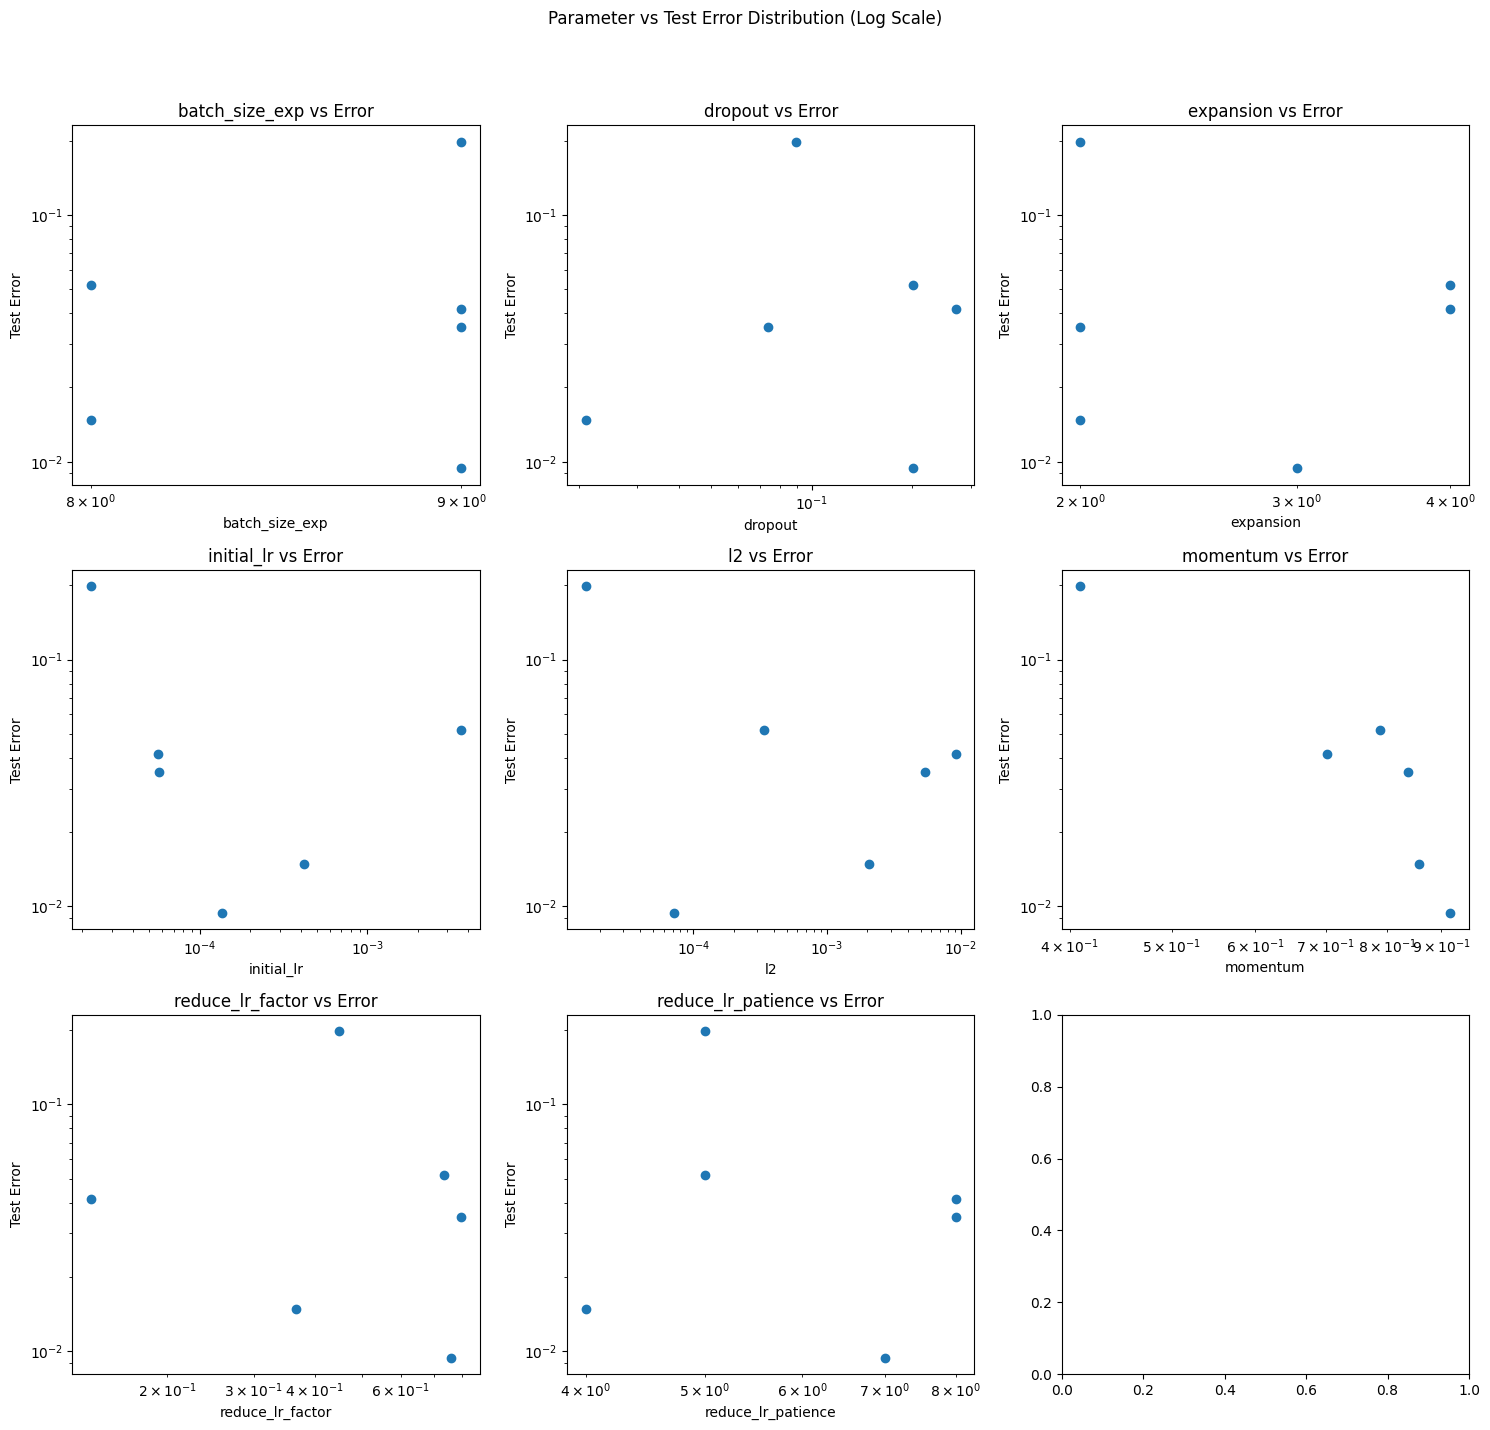

In [11]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the JSON data from the provided files
with open('/content/drive/My Drive/HW4_results/configs.json') as f:
    configs = [json.loads(line) for line in f]

with open('/content/drive/My Drive/HW4_results/results.json') as f:
    results = [json.loads(line) for line in f]

# Extract parameters and accuracies
configs_data = [config[1] for config in configs]
results_data = [result[3]['info']['test_accuracy'] for result in results]

# Combine configs and results by line
combined_data = [
    {**config, 'test_error': 1 - result}  # Calculate error
    for config, result in zip(configs_data, results_data)
]

# Convert to DataFrame
df = pd.DataFrame(combined_data)

# Plot error distributions by parameters
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
fig.suptitle('Parameter vs Test Error Distribution (Log Scale)')

params = ['batch_size_exp', 'dropout', 'expansion', 'initial_lr', 'l2', 'momentum', 'reduce_lr_factor', 'reduce_lr_patience']

for ax, param in zip(axes.flat, params):
    ax.scatter(df[param], df['test_error'])
    ax.set_xscale('log')  # Set x-axis to log scale
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.set_xlabel(param)
    ax.set_ylabel('Test Error')
    ax.set_title(f'{param} vs Error')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [ ]:
import json
import pickle
import matplotlib.pyplot as plt
import os
from google.colab import drive

# Google Drive 마운트
drive.mount('/content/drive')
SAVE_DIR = '/content/drive/My Drive/HW4_results'  # 저장할 경로 설정
# 저장된 결과 파일 경로
result_file = os.path.join(SAVE_DIR, 'results.pkl')

# 결과 불러오기
with open(result_file, 'rb') as f:
    result = pickle.load(f)

# get all executed runs
all_runs = result.get_all_runs()

# get the 'dict' that translates config ids to the actual configurations
id2conf = result.get_id2config_mapping()

results = []
for entry in all_runs:
        test_accuracy = entry['info']['test_accuracy']
        results.append(test_accuracy)

# 실험 인덱스 생성
indices = range(len(results))

# 최고 테스트 정확도 값 추적
max_accuracy = []
current_max = 0
for accuracy in results:
    if accuracy > current_max:
        current_max = accuracy
    max_accuracy.append(current_max)

# 테스트 정확도 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(indices, results, 'bo', label='Test Accuracy')

# 최고 기록 점 표시
for i, (x, y) in enumerate(zip(indices, results)):
    if y == max_accuracy[i]:
        plt.plot(x, y, 'ro')
        plt.text(x, y, f'{y:.4f}', fontsize=9, verticalalignment='bottom', horizontalalignment='right')

# 최고 기록을 잇는 선 그리기
plt.plot(indices, max_accuracy, 'r-', label='High Score')

# 세밀한 y축 범위 설정
plt.ylim(0.96, 1.0)
plt.yticks([0.96, 0.97, 0.98, 0.99, 1.0])

# 그래프 라벨 및 제목 추가
plt.xlabel('Experiment Index')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Time')
plt.legend()
plt.show()
